<a href="https://colab.research.google.com/github/sharmashubam/pyTorch_basics/blob/main/03_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

torch.__version__


'2.0.0+cu118'

In [2]:
# train
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None 
)

# testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 18695469.61it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 345901.08it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6164105.75it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5473327.50it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



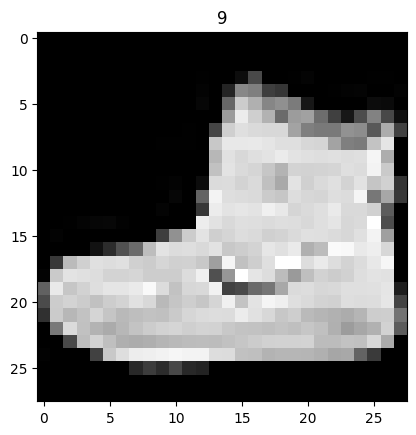

In [3]:
img, label = train_data[0]
img.shape
plt.imshow(img.squeeze() , cmap='gray')
plt.title(label);

In [5]:
from torch.utils.data import DataLoader

BATCH_SIZE= 32
train_dataloader = DataLoader(train_data,
    batch_size=BATCH_SIZE, 
    shuffle=True
) 



test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle = True)


# print(len(train_dataloader) , len(test_dataloader))

# didnot understand this

train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_labels_batch)


tensor([8, 8, 2, 2, 5, 1, 3, 5, 3, 4, 9, 5, 9, 2, 5, 5, 3, 8, 5, 3, 4, 3, 0, 8,
        8, 3, 8, 8, 0, 2, 6, 4])


In [6]:
# baseline model (model_0)

flatten_model = nn.Flatten()



In [7]:
from torch import nn
class FirstModelV0(nn.Module):
  def __init__(self, input_shape: int ,hidden_units: int , output_shape:int ):
    super().__init__()
    self.layer_stack= nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= input_shape, out_features= hidden_units),
        nn.Linear(in_features= hidden_units, out_features=output_shape)

    )

  def forward(self, x):
    return self.layer_stack(x)


In [8]:
# See classes
class_names = train_data.classes
class_names


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [27]:
import torch
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [28]:

model_0 = FirstModelV0(input_shape=784, # one for every pixel (28x28)
    hidden_units=10,
    output_shape=len(class_names)
)

model_0
model_0.to(device)

FirstModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [10]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [11]:
# Import accuracy metric
from helper_functions import accuracy_fn 

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.05)


In [12]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
def accuracy_fn(y_pred,y_true):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [13]:
torch.manual_seed(42)

epochs= 3

for epoch in range(epochs):
  train_loss=0

  for batch, (X,y) in enumerate(train_dataloader):
    model_0.train()

    # do teh forward pass
    y_pred = model_0(X)

    # calculate the loss
    train_loss += loss_fn(y_pred ,y)

    # optimizer
    optimizer.zero_grad()  

    # step ,step , step
    optimizer.step()
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    
  train_loss /= len(train_dataloader)

  # testing

  model_0.eval()
  test_loss, test_acc = 0, 0 
  with torch.inference_mode() :
    for X, y in test_dataloader:
      test_pred = model_0(X)

      # calculate the loss
      test_loss += loss_fn(test_pred, y)

      test_acc+= accuracy_fn(y_true=y, y_pred=torch.softmax(test_pred, dim=1).argmax(dim=1)) 

    
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"\nTrain loss: {train_loss:.2f} | Test loss: {test_loss:.2f}, Test acc: {test_acc:.2f}%\n")



Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 2.30 | Test loss: 2.30, Test acc: 9.53%

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 2.30 | Test loss: 2.30, Test acc: 9.53%

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 2.30 | Test loss: 2.30, Test acc: 9.52%



'cuda'

In [29]:
# function to test the model and get the results
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
          X, y = X.to(device), y.to(device)
          y_pred = model(X)
          loss += loss_fn(y_pred, y)
          acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        

        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)

model_0_results

{'model_name': 'FirstModelV0',
 'model_loss': 2.377246856689453,
 'model_acc': 10.083865814696486}

In [16]:
# crearting model_1 , adding some non-linearity
class SecondModel_2(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int , output_shape: int ):
    super().__init__()
    self.layer_stack=nn.Sequential(
        
        nn.Flatten(),
        nn.Linear(in_features= input_shape, out_features= hidden_units),
        nn.ReLU(),
        nn.Linear(in_features= hidden_units, out_features=output_shape),
        nn.ReLU()

    )

  def forward(self, x):
    return self.layer_stack(x)


In [31]:
model_01 = SecondModel_2(input_shape = 784,
                         hidden_units = 6,
                         output_shape= len(class_names)
                          ).to(device)

#  device on which the first parameter tensor of model_01 is located.
next(model_01.parameters()).to(device)

Parameter containing:
tensor([[-0.0078,  0.0072, -0.0174,  ..., -0.0354,  0.0187,  0.0085],
        [-0.0182,  0.0344, -0.0162,  ...,  0.0017,  0.0045,  0.0133],
        [-0.0108, -0.0213,  0.0084,  ...,  0.0273, -0.0081,  0.0026],
        [ 0.0231,  0.0155,  0.0046,  ..., -0.0126,  0.0109,  0.0021],
        [-0.0234, -0.0240, -0.0349,  ...,  0.0067,  0.0311,  0.0163],
        [ 0.0350, -0.0151, -0.0171,  ...,  0.0005,  0.0119,  0.0352]],
       device='cuda:0', requires_grad=True)

In [18]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_01.parameters(), 
                            lr=0.1)


In [19]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0

    model.train()
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                        y_pred=torch.softmax(y_pred,dim=1).argmax(dim=1))

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"\nTrain loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


# test step
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  
    test_loss, test_acc = 0, 0

    model.eval() 
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # do the Forward pass
            test_pred = model(X)
            
            #  Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=torch.softmax(test_pred, dim=1).argmax(dim=1)
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [42]:
from tqdm import tqdm
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_01, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_01,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------

Train loss: 2.31603 | Train accuracy: 9.77%


 10%|█         | 1/10 [00:11<01:45, 11.76s/it]

Test loss: 2.31574 | Test accuracy: 9.84%

Epoch: 1
---------

Train loss: 2.31603 | Train accuracy: 9.77%


 20%|██        | 2/10 [00:23<01:32, 11.58s/it]

Test loss: 2.31572 | Test accuracy: 9.83%

Epoch: 2
---------

Train loss: 2.31603 | Train accuracy: 9.77%


 30%|███       | 3/10 [00:34<01:20, 11.50s/it]

Test loss: 2.31559 | Test accuracy: 9.87%

Epoch: 3
---------

Train loss: 2.31603 | Train accuracy: 9.77%


 40%|████      | 4/10 [00:46<01:09, 11.64s/it]

Test loss: 2.31563 | Test accuracy: 9.88%

Epoch: 4
---------

Train loss: 2.31603 | Train accuracy: 9.77%


 50%|█████     | 5/10 [00:58<00:59, 11.90s/it]

Test loss: 2.31566 | Test accuracy: 9.85%

Epoch: 5
---------

Train loss: 2.31603 | Train accuracy: 9.77%


 60%|██████    | 6/10 [01:10<00:46, 11.74s/it]

Test loss: 2.31576 | Test accuracy: 9.85%

Epoch: 6
---------

Train loss: 2.31603 | Train accuracy: 9.77%


 70%|███████   | 7/10 [01:21<00:35, 11.67s/it]

Test loss: 2.31570 | Test accuracy: 9.84%

Epoch: 7
---------

Train loss: 2.31603 | Train accuracy: 9.77%


 80%|████████  | 8/10 [01:33<00:23, 11.65s/it]

Test loss: 2.31569 | Test accuracy: 9.85%

Epoch: 8
---------

Train loss: 2.31603 | Train accuracy: 9.77%


 90%|█████████ | 9/10 [01:44<00:11, 11.59s/it]

Test loss: 2.31576 | Test accuracy: 9.84%

Epoch: 9
---------

Train loss: 2.31603 | Train accuracy: 9.77%


100%|██████████| 10/10 [01:56<00:00, 11.62s/it]

Test loss: 2.31577 | Test accuracy: 9.83%

Train time on cuda: 116.190 seconds


In [43]:
torch.manual_seed(42)

model_1_results = eval_model(model=model_01, 
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn) 
model_1_results


{'model_name': 'SecondModel_2',
 'model_loss': 2.315657377243042,
 'model_acc': 9.844249201277956}

## Adding CNN to our baseline model

In [34]:
class FashionMNISTModelV2(nn.Module):
    
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(input_shape, 
                      hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)

        x = self.block_2(x)
        
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [35]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

In [36]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------

Train loss: 0.59615 | Train accuracy: 78.39%


 33%|███▎      | 1/3 [00:19<00:38, 19.12s/it]

Test loss: 0.40478 | Test accuracy: 85.38%

Epoch: 1
---------

Train loss: 0.36041 | Train accuracy: 86.90%


 67%|██████▋   | 2/3 [00:33<00:16, 16.32s/it]

Test loss: 0.38329 | Test accuracy: 86.41%

Epoch: 2
---------

Train loss: 0.32493 | Train accuracy: 88.33%


100%|██████████| 3/3 [00:47<00:00, 15.71s/it]

Test loss: 0.34250 | Test accuracy: 87.68%

Train time on cuda: 47.153 seconds


In [38]:
# Get model_2 results 
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3414980173110962,
 'model_acc': 87.72963258785943}

In [44]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FirstModelV0,2.377247,10.083866
1,SecondModel_2,2.315657,9.844249
2,FashionMNISTModelV2,0.341498,87.729633


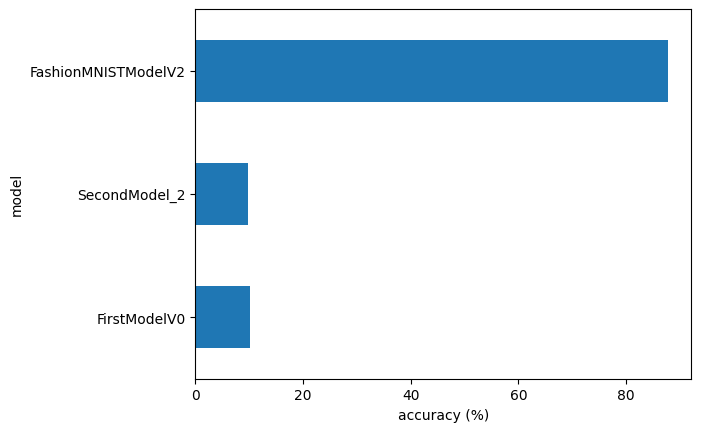

In [45]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");